In [1]:
import time

import torch

from childnet import ChildNetwork
from cifar10_training import Cifar10Trainer
from controller import ControllerNetwork
from controller_training import ControllerTrainer

In [2]:
outer_iterations = 310  #310
controller_iterations = 2000  #2000
child_iterations = 400  #400
##
hidden_size = 100
num_layer_types = 4
num_layers = 5
num_filters = 32
num_classes = 10  # cifar-10 dataset
batch_size = 128
# grad_clip_value = 0.15
##
val_accuracy_list = []

train_time_list = []

In [3]:
cifar10_trainer = Cifar10Trainer(batch_size=batch_size)
controller = ControllerNetwork(hidden_size, num_layers, num_layer_types)
controller_trainer = ControllerTrainer(controller, cifar10_trainer, num_hidden_layers=num_layers,
                                       num_filters=num_filters,
                                       num_classes=num_classes, batch_size=batch_size)
load_previous_network_weights = None

what is the device? cpu or gpu ?  cuda
Files already downloaded and verified
Files already downloaded and verified


In [4]:
for i in range(outer_iterations):
    start = time.time()
    print("ITERATION NUMBER %d" % (i + 1))
    ############## sample model ##############
    print('Controller is sampling architecture...')
    soft_1, soft_2, layers_types, skip_connections = controller()
    #
    print(torch.exp(soft_1))
    print(layers_types)
    # print(torch.exp(soft_2))
    # print(skip_connections)
    ############## initialize weights ##############
    print('Creating new child network...')
    if i == 0:
        load_previous_network_weights = False
    child_net = ChildNetwork(layers_types, skip_connections, load_previous_network_weights,
                             num_hidden_layers=num_layers,
                             num_filters=num_filters, num_classes=num_classes)
    load_previous_network_weights = True

    ############## train model ##############
    print('Training child network...')
    # cifar10_trainer.shuffle_and_load_data_again()
    val_accuracy, train_time = cifar10_trainer.train(child_net, num_of_steps=child_iterations)
    val_accuracy_list.append(val_accuracy)
    train_time_list.append(train_time)
    ############## train controller ##############
    print('Training controller network')
    # baseline = weighted_moving_average(val_accuracy_list)
    # multiplier = val_accuracy - baseline  # (reward - baseline)
    # print('val_accuracy is = ', val_accuracy)
    # print('baseline is = ', baseline)
    # print('multiplier is = ', multiplier)
    # controller_trainer.train(num_of_steps=controller_iterations, grad_clip_value=grad_clip_value)
    controller_trainer.train(num_of_steps=controller_iterations)
    ##############################################
    end = time.time()
    total_time = end - start
    print('total time of 1 outer iteration is {:.2f}'.format(total_time))
    print('##############################################')
    print('##############################################')

ITERATION NUMBER 1
Controller is sampling architecture...
tensor([[[0.2394, 0.2537, 0.2605, 0.2464]],

        [[0.2409, 0.2514, 0.2591, 0.2485]],

        [[0.2400, 0.2512, 0.2594, 0.2494]],

        [[0.2399, 0.2525, 0.2590, 0.2485]],

        [[0.2404, 0.2516, 0.2591, 0.2488]],

        [[0.2405, 0.2510, 0.2588, 0.2497]],

        [[0.2389, 0.2530, 0.2598, 0.2482]],

        [[0.2401, 0.2523, 0.2594, 0.2482]],

        [[0.2382, 0.2538, 0.2611, 0.2469]],

        [[0.2390, 0.2554, 0.2575, 0.2481]]], grad_fn=<ExpBackward>)
tensor([[[0., 0., 0., 1.]],

        [[0., 0., 0., 0.]],

        [[0., 0., 1., 0.]],

        [[0., 0., 0., 0.]],

        [[1., 0., 0., 0.]],

        [[0., 0., 0., 0.]],

        [[0., 0., 1., 0.]],

        [[0., 0., 0., 0.]],

        [[0., 0., 1., 0.]],

        [[0., 0., 0., 0.]]])
Creating new child network...
Training child network...
The training time for 400 steps is: 28.35 seconds
The validation time on whole validation set is 1.11 seconds
The validatio

KeyboardInterrupt: 

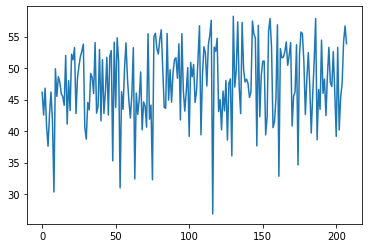

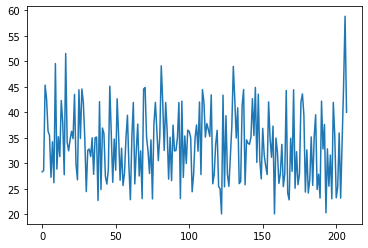

In [5]:
import matplotlib.pyplot as plt

plt.plot(val_accuracy_list)
plt.figure()
plt.plot(train_time_list)

In [6]:
soft_1, soft_2, layers_types, skip_connections = controller()
print(skip_connections)
print(torch.exp(soft_2))

tensor([[[0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0.]]])
tensor([[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000, 1.0000, 1.0000]],

        [[0.4686, 0.4848, 0.4895, 0.4927, 0.4721]],

        [[0.4855, 0.4886, 0.4933, 0.4930, 0.5011]],

        [[0.3262, 0.3260, 0.3272, 0.3192, 0.3329]],

        [[0.3036, 0.3196, 0.3257, 0.3263, 0.3072]],

        [[0.2248, 0.2382, 0.2422, 0.2412, 0.2272]],

        [[0.2221, 0.2390, 0.2452, 0.2456, 0.2295]],

        [[0.1804, 0.1913, 0.1951, 0.1928, 0.1825]],

        [[0.1791, 0.2000, 0.1980, 0.1940, 0.1846]]], grad_fn=<ExpBackward>)
